In [2]:
from BasisFilter import BasisFilter
import pandas as pd
import os
import copy
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [3]:
def standardize_numeric_features(df):
    # 수치형 변수 선택
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
    
    # 0과 1만 존재하는 열은 제외
    non_binary_features = []
    for feature in numeric_features:
        if not set(df[feature].unique()).issubset({0, 1}):
            non_binary_features.append(feature)
    
    # StandardScaler를 사용하여 표준화
    scaler = StandardScaler()
    df[non_binary_features] = scaler.fit_transform(df[non_binary_features])
    
    return df

import numpy as np

# 예시 혼동 행렬

def print_confusion_matrix(cm, class_names):
    """
    혼동 행렬을 콘솔에 보기 좋게 출력하는 함수
    """
    # 혼동 행렬의 행렬을 텍스트로 변환
    print("Confusion Matrix:")
    print(" " * 12, end="")
    for name in class_names:
        print(f"{name:>8}", end=" ")
    print()
    
    for i, row in enumerate(cm):
        print(f"{class_names[i]:<12}", end=" ")
        for value in row:
            print(f"{value:>8}", end=" ")
        print()

# 클래스 이름 지정
class_names = ['Class 0', 'Class 1']



In [4]:
BF = BasisFilter()
df = pd.read_excel(f'{BF.path}//filtered_data//딥러닝 모델 데이터셋.xlsx')

In [5]:
basis = BF.load_basis()

C:\Users\howsr\workspace\1_DataPreprocessing\basis\code\정성준 개인 프로젝트\BasisFilter.py:36: DtypeWarning: Columns (2,69,70,71,72,99,100,101,102,129,130,131,132,159,160,161,162,189,190,191,192,219,220,221,222,249,250,251,252,279,280,281,282,309,310,311,312,339,340,341,342,369,370,371,372,399,400,401,402,429,430,431,432,459,460,461,462,489,490,491,492,519,520,521,522,549,550,551,552,579,580,581,582,609,610,611,612,639,640,641,642,669,670,671,672,699,700,701,702,729,730,731,732,759,760,761,762,789,790,791,792) have mixed types. Specify dtype option on import or set low_memory=False.
  self.basis = pd.read_csv(f'{self.path}\\MergeRegionData\\basis_for_filter.csv', encoding='utf-8')


In [6]:
basis = pd.read_csv(f'{BF.path}//filtered_data//progress_info.csv')

C:\Users\howsr\AppData\Local\Temp\ipykernel_26736\54309853.py:1: DtypeWarning: Columns (267,268,295,296,297,298,325,326,327,328,355,356,357,358,385,386,387,388,415,416,417,418,445,446,447,448,475,476,477,478,505,506,507,508,535,536,537,538,565,566,567,568,595,596,597,598,625,626,627,628,655,656,657,658,685,686,687,688,715,716,717,718,745,746,747,748,775,776,777,778,805,806,807,808) have mixed types. Specify dtype option on import or set low_memory=False.
  basis = pd.read_csv(f'{BF.path}//filtered_data//progress_info.csv')


In [8]:
date_col = [col for col in basis.columns if 'Date' in col]
for col in date_col:
    #print(progress_info_adult[col])
    basis[col] = pd.to_datetime(basis[col])

In [9]:
def extract_weight(text):
    if pd.isna(text):
        return None
    # 정규 표현식 패턴
    pattern =  r'체\s*중\s*:\s*(?:\(\s*)?(\d+(\.\d+)?)\s*(?:\))?'
    # 텍스트에서 체중 추출
    match = re.search(pattern, text)
    if match:
        weight = match.group(1)
        if float(weight) < 30 or float(weight) > 200:
            return None
        return float(weight)
    else:
        return None

In [10]:
basis = basis.dropna(subset = 'N', axis = 0)

In [11]:
basis['N'].value_counts()

N
1.0    44463
2.0      263
3.0       49
4.0        3
Name: count, dtype: int64

In [17]:
from datetime import datetime, timedelta
patient_dict={}
nan=''

for idx in basis.index:
    num = int(basis.loc[idx,'N'])
    Date = f'Date_{num}'
    first_date = basis.loc[idx,Date]
    patient_dict[idx] = {}
    count = 1
    med_list = []
    memo_list = []
    while True:
        #print(f'num:{num}, count:{count}, {basis.loc[idx,Date]}')
        Date = f'Date_{num}'
        MedicineName = f'MedicineName_{num}'
        Memo = f'Memo_{num}'
        ProgressNote = f'ProgressNote_{num}'
        Weight = f'Weight_{num}'
        num += 1
        #탈출조건
        if num >= 27:
            break
        if pd.isna(basis.loc[idx,Date]):
            patient_dict[idx][f'Medicine_{count-1}'] = med_list
            patient_dict[idx][f'Memo_{count-1}'] = memo_list
            #print(f'\n{idx}, {patient_dict[idx]}\n')
            break
        #기간계산
        if count == 1:
            FirstDate = basis.loc[idx,Date]
            patient_dict[idx]['FirstDate'] = FirstDate
        
        # 채중과 채중 감량, 약처방, 경과 기간 입력 입력
        if 'Weight_1' not in patient_dict[idx].keys():
            patient_dict[idx]['Weight_1'] = basis.loc[idx,'Weight']
            count +=1 
        elif pd.isna(basis.loc[idx,Weight]):
            W = extract_weight(basis.loc[idx,ProgressNote])
            if W != None:
                patient_dict[idx][f'Medicine_{count-1}'] = med_list
                patient_dict[idx][f'Memo_{count-1}'] = memo_list
                med_list, memo_list = [], []
                #기간 입력
                patient_dict[idx][f'Period_{count}'] = (basis.loc[idx,Date] - patient_dict[idx]['FirstDate']).days
                
                patient_dict[idx][f'Weight_{count}'] = W
                patient_dict[idx][f'LossWeight_{count}'] = round(patient_dict[idx]['Weight_1'] - W, 4)
                count +=1 
        else:
            patient_dict[idx][f'Medicine_{count-1}'] = med_list
            patient_dict[idx][f'Memo_{count-1}'] = memo_list
            med_list, memo_list = [], []
            #기간 입력
            patient_dict[idx][f'Period_{count}'] = (basis.loc[idx,Date] - patient_dict[idx]['FirstDate']).days
            patient_dict[idx][f'Weight_{count}'] = basis.loc[idx,Weight]
            patient_dict[idx][f'LossWeight_{count}'] = round(patient_dict[idx]['Weight_1'] - patient_dict[idx][f'Weight_{count}'], 4)
            count +=1

        if not pd.isna(basis.loc[idx,MedicineName]):
            med_list = med_list + eval(basis.loc[idx,MedicineName])
            memo_list = memo_list + eval(basis.loc[idx,Memo])
        #print(f'{idx}, {patient_dict[idx]}')
  

In [18]:
df = pd.DataFrame(patient_dict).transpose()

In [19]:
cols = ['Weight_1'] + [col for col in df.columns if 'LossWeight' in col or 'Period' in col]

In [20]:
df_summary = df[cols]

In [21]:
df_summary

,Weight_1,Period_2,LossWeight_2,Period_3,LossWeight_3,Period_4,LossWeight_4,Period_5,LossWeight_5,Period_6,...,Period_12,LossWeight_12,Period_13,LossWeight_13,Period_14,LossWeight_14,Period_15,LossWeight_15,Period_16,LossWeight_16
0,55.0,14,0.0,53,1.0,159,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52.0,17,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54.0,16,3.0,35,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44824,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44825,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44826,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44827,99.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
LossWeightCols = [col for col in df_summary if 'LossWeight' in col]

In [33]:
for i in range(2,17):
    imsi = df_summary[['Weight_1',f'Period_{i}',f'LossWeight_{i}']]
    #print(i, imsi.shape)
    imsi = imsi.dropna()
    #print(i, imsi.shape)
    imsi['PercentOfLoss'] = (imsi[f'LossWeight_{i}'] / imsi['Weight_1'])*100
    imsi['Period'] = imsi[f'Period_{i}']
    #print(imsi[['Period','PercentOfLoss']])
    if i == 2:
        Period_PercentOfLoss =imsi[['Weight_1', 'Period','PercentOfLoss']]
    else:
        Period_PercentOfLoss = pd.concat([Period_PercentOfLoss, imsi[['Weight_1','Period','PercentOfLoss']]], axis = 0)


(33435, 3)
(56540, 3)
(71049, 3)
(79185, 3)
(83696, 3)
(86056, 3)
(87263, 3)
(87877, 3)
(88154, 3)
(88276, 3)
(88339, 3)
(88369, 3)
(88383, 3)
(88389, 3)
(88390, 3)


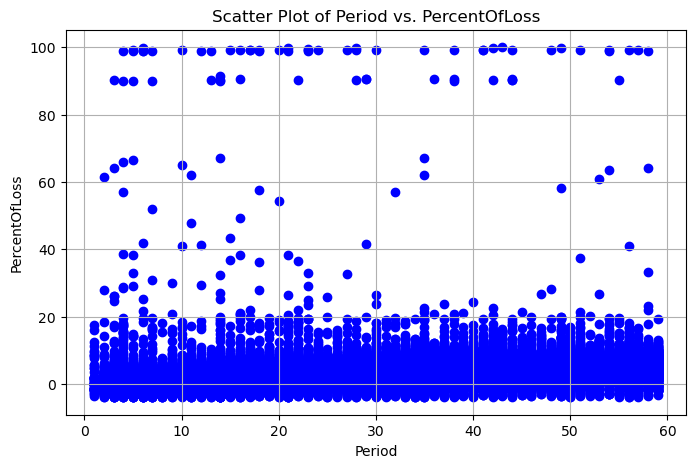

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

df = Period_PercentOfLoss[Period_PercentOfLoss['PercentOfLoss'] > -4]
df = df[df['Period'] < 60]

# 산점도 그리기
plt.figure(figsize=(8, 5))
plt.scatter(df['Period'], df['PercentOfLoss'], color='blue', marker='o')

# 그래프 제목 및 축 레이블 추가
plt.title('Scatter Plot of Period vs. PercentOfLoss')
plt.xlabel('Period')
plt.ylabel('PercentOfLoss')

# 그래프 출력
plt.grid(True)
plt.show()


In [129]:
max(df['PercentOfLoss'])

1.0